In [2]:
%load_ext autoreload
%autoreload 2

import sys, os
import numpy as np, pandas as pd

import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")


%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.pyplot import NullFormatter
import matplotlib
from matplotlib.colors import LogNorm
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 30}
matplotlib.rc('font', **font)

import seaborn as sns
rc={'font.size': 16, 'axes.labelsize': 16, 'legend.fontsize': 12,
    'axes.titlesize': 18, 'xtick.labelsize': 12, 'ytick.labelsize': 12}
sns.set(font="serif",style="white",rc=rc)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Running selection function

In [3]:
folder = '/home/andy/Documents/Research/SF/SFdata/Galaxia_data/'
iso_folder = '/home/andy/Documents/Research/SF/SFdata/'

In [6]:
sys.path.append('/home/andy/Documents/Research/SF/GitRepo/seestar/')
import StatisticalModels as sm

In [12]:
sys.path.append('/home/andy/Documents/Research/SF/GitRepo/seestar/')
import SelectionGrid, IsochroneScaling, StatisticalModels, SFInstanceClasses

## Generate selection function from scratch

We have prebuilt the 3 component GMM selection functions so only use gen_obsSF() if you wish to rebuild (takes about 20' on 3 cores).

gen_intSF() takes less than a minute so this is fine.

In [14]:
survey = pd.read_csv(folder + '/Galaxia_sf_survey.csv')
survey['Colour'] = survey.Japp-survey.Kapp

pointings = pd.read_csv(folder + '/Galaxia_sf_fieldinfo.csv')
pointings = pointings[['fieldID', 'glon', 'glat', 'halfangle','Magmin', 'Magmax', 'Colmin', 'Colmax']]
pointings.rename({'glon':'phi', 'glat':'theta'})

def get_spectro(field):
    
    field_data = survey[survey.fieldID==field]
    field_data = np.array(field_data[['Happ', 'Colour']])
    
    return field_data

def get_photo(field):
    
    file_path = folder + '/photometric/'+str(field)+'.csv'
    field_data = pd.read_csv(file_path, usecols=['Japp', 'Happ', 'Kapp'])
    
    field_data['Colour'] = field_data.Japp - field_data.Kapp
    field_data = np.array(field_data[['Happ', 'Colour']])
    
    return field_data

In [15]:
pointings = pointings[1:]
pointings.Magmin = 'NoLimit'
pointings.Magmax = 'NoLimit'
pointings.Colmin = 'NoLimit'

In [16]:
SF = SelectionGrid.SFGenerator(get_spectro, get_photo, pointings, 
                              spectro_model=('BGM_TNC', None), photo_model=('BGM_TNC', None))

The spectro model description is:('BGM_TNC', None)
The photo model description is:('BGM_TNC', None)


In [18]:
%%time
# Load in the isochrone interpolant
IsoCalculator = IsochroneScaling.IntrinsicToObservable()
IsoCalculator.LoadColMag(iso_folder+'isochrones/isochrone_interpolantinstances.pickle')

ImportError: No module named 'dill.dill'

## Generate new selection functions

In [19]:
%%time
SF.gen_obsSF(folder+'/Galaxia_obsSF.pickle')

Creating colour-magnitude field interpolants...
Finished col-mag calculation: 2.0, 1/2, Time: 0.00m, Left: 0.00mN stars =  4481
Running BGM
2   BIC:  -43593.345693955605    lnP:  21847.11845606652
3   BIC:  -44342.557997416436    lnP:  22246.947412341295
4   BIC:  -44970.95906246137    lnP:  22586.370749408117
5   BIC:  -45401.44016709017    lnP:  22826.834106266877
6   BIC:  -45593.328934123674    lnP:  22948.001294327987
7   BIC:  -45658.81231534487    lnP:  23005.965789482943
8   BIC:  -45675.71891642805    lnP:  23039.641894568893
9   BIC:  -45689.20496814816    lnP:  23071.607724973306
10   BIC:  -45696.53746813884    lnP:  23100.496779513007
11   BIC:  -45677.33360852578    lnP:  23116.117654250833
12   BIC:  -45591.82989183584    lnP:  23098.58860045022
Best components:  10
Param shape:  (10, 6)

N stars =  294
Prior boundaries:  [[-6.87932038  2.17005523]
 [-7.81057041  5.36044332]]
True Converged (|f_n-f_(n-1)| ~= 0)
2    BIC:  1755.3400421158801    lnP:  -843.568542453908
Tru

In [23]:
instsf = SF.obsSF[2.0].SF_model
instdf = SF.obsSF[2.0].DF_model
params_df = instsf.params_df

In [24]:
phot = pd.read_csv('/home/andy/Documents/Research/data/asfe2/Projects/sf_data/Galaxia_data/photometric/3.0.csv')
x = phot.Happ
y = phot.Japp-phot.Kapp
xs = (x-instsf.mux)/instsf.sx
ys = (y-instsf.muy)/instsf.sy

sf_params = instsf.params_f_scaled.copy()
pSelect = StatisticalModels.bivGaussMixture(sf_params, xs, ys)
uncut = (x<13.5)&(y>0.5)
len(instsf.x), np.sum(pSelect), np.sqrt(np.sum(pSelect)), np.sum(pSelect*uncut), np.sqrt(np.sum(pSelect*uncut))

(294,
 311.35372211749984,
 17.645218109094028,
 295.9278246381296,
 17.202552852356817)

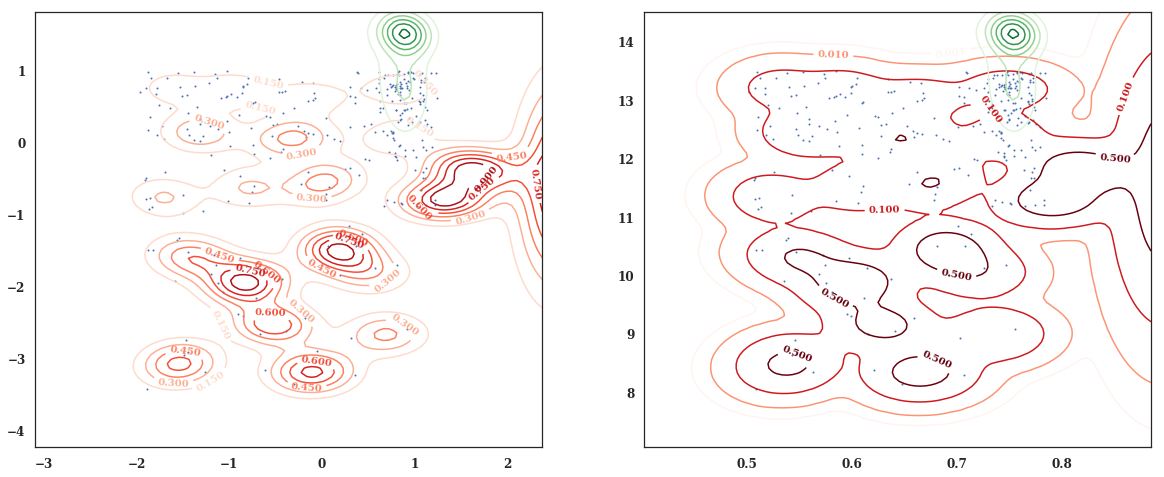

In [25]:
fig, axes = plt.subplots(1,2,figsize=(20,8))

plt.sca(axes[0])
plt.scatter(instsf.y_s, instsf.x_s, s=1)
x = np.linspace(instsf.rngy_s[0], instsf.rngy_s[1], 100)
y = np.linspace(instsf.rngx_s[0], instsf.rngx_s[1], 100)
xx, yy = np.meshgrid(x, y)
zz = StatisticalModels.bivGaussMixture(instsf.params_f_scaled, yy, xx)
CS = plt.contour(x, y, zz, cmap='Reds')
plt.clabel(CS, inline=1, fontsize=10)
zz = StatisticalModels.bivGaussMixture(instsf.params_df, yy, xx)
plt.contour(x, y, zz, cmap='Greens')
#plt.colorbar()

plt.sca(axes[1])
plt.scatter(instsf.y, instsf.x, s=1)
x = np.linspace(instsf.rngy[0], instsf.rngy[1], 100)
y = np.linspace(instsf.rngx[0], instsf.rngx[1], 100)
xx, yy = np.meshgrid(x, y)
zz = StatisticalModels.bivGaussMixture(instsf.params_f, yy, xx)
CS = plt.contour(x, y, zz, cmap='Reds', norm=LogNorm(), levels=(0.001, 0.01, 0.1, 0.5))
plt.clabel(CS, inline=1, fontsize=10)
zz = StatisticalModels.bivGaussMixture(instdf.params_f, yy, xx)
plt.contour(x, y, zz, cmap='Greens')
#plt.colorbar()